In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix,accuracy_score

In [2]:
class DropoutNetwork(nn.Module):
    def __init__(self,input_dim,output_dim,proba_drop):
        #assign module after called Module.__init__() 
        super(DropoutNetwork, self).__init__()
        #basic parameters
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.proba_drop=proba_drop
        self.hidden_dim=int((input_dim+output_dim)/2)
        #construction of layers
        self.layer1=nn.Linear(input_dim,self.hidden_dim)
        self.layer2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.layer3=nn.Linear(self.hidden_dim,self.output_dim)
        #nn.init.normal_(self.layer1.weight)
        #nn.init.normal_(self.layer2.weight)
        #nn.init.normal_(self.layer3.weight)
        
    def forward(self, xdata,drop_inplace=False):
        #inplace=False means input vector will not be changed
        
        input=xdata.view(-1,self.input_dim)
        input=F.dropout(input,p=self.proba_drop,training=True,inplace=drop_inplace)
        #Pass layer 1
        input=self.layer1(input)
        #Remark: training = True may be change to self.training to compare pred MCdropout and pred naive.
        input=F.dropout(input,p=self.proba_drop,training=True,inplace=drop_inplace)
        input=F.relu(input)
        #Pass layer 2
        input=self.layer2(input)
        input=F.dropout(input,p=self.proba_drop,training=True,inplace=drop_inplace)
        input=F.relu(input)
        #Pass layer 3 to get the output
        output=self.layer3(input)
        
        return output

Parameters

In [3]:
batch_size=256
learning_rate=1e-3 #may be changed to adaptive rate
cuda=False
device = torch.device("cpu") #"cuda" if args.cuda else 
input_dim=28*28
nclasses=10
p_drop=0.5
n_epochs=50

In [4]:
model=DropoutNetwork(input_dim,nclasses,p_drop)
model.load_state_dict(torch.load("model_mcdropout_4couches_class.pt"))
model.eval()

DropoutNetwork(
  (layer1): Linear(in_features=784, out_features=397, bias=True)
  (layer2): Linear(in_features=397, out_features=397, bias=True)
  (layer3): Linear(in_features=397, out_features=10, bias=True)
)

In [7]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=False,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [6]:
def train(n_epochs=50,display_step=10,criterion = nn.CrossEntropyLoss()):
    model.train()
    
    for epoch in range(n_epochs):
        epoch_loss=0
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/(epoch+1))
        
        for batch_idx, (xdata,ydata) in enumerate(train_loader):
            #if we have cuda
            xdata=xdata.to(device)
            ydata=ydata.to(device)

            optimizer.zero_grad()
            output=model(xdata)
            
            loss=criterion(output,ydata)
            epoch_loss+=loss.item()
            loss.backward()
            optimizer.step()
            
            if batch_idx % display_step==0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)] lr: {}\tLoss: {:.6f}'
                  .format(epoch+1, batch_idx * len(ydata),
                          len(train_loader.dataset),
                          100. * batch_idx / len(train_loader),
                          learning_rate/(epoch+1), loss.item()))
        print("Finish {} epoch(s). Epoch loss: {}.".format(epoch+1,epoch_loss/len(train_loader)))
        

In [7]:
train()

Train Epoch: 1 [0/60000 (0%)] lr: 0.001	Loss: 2.313394
Train Epoch: 1 [2560/60000 (4%)] lr: 0.001	Loss: 1.921445
Train Epoch: 1 [5120/60000 (9%)] lr: 0.001	Loss: 1.154935
Train Epoch: 1 [7680/60000 (13%)] lr: 0.001	Loss: 0.832125
Train Epoch: 1 [10240/60000 (17%)] lr: 0.001	Loss: 0.556421
Train Epoch: 1 [12800/60000 (21%)] lr: 0.001	Loss: 0.734099
Train Epoch: 1 [15360/60000 (26%)] lr: 0.001	Loss: 0.580680
Train Epoch: 1 [17920/60000 (30%)] lr: 0.001	Loss: 0.575509
Train Epoch: 1 [20480/60000 (34%)] lr: 0.001	Loss: 0.607367
Train Epoch: 1 [23040/60000 (38%)] lr: 0.001	Loss: 0.737628
Train Epoch: 1 [25600/60000 (43%)] lr: 0.001	Loss: 0.513815
Train Epoch: 1 [28160/60000 (47%)] lr: 0.001	Loss: 0.476240
Train Epoch: 1 [30720/60000 (51%)] lr: 0.001	Loss: 0.450930
Train Epoch: 1 [33280/60000 (55%)] lr: 0.001	Loss: 0.538456
Train Epoch: 1 [35840/60000 (60%)] lr: 0.001	Loss: 0.538487
Train Epoch: 1 [38400/60000 (64%)] lr: 0.001	Loss: 0.462425
Train Epoch: 1 [40960/60000 (68%)] lr: 0.001	Loss:

Train Epoch: 6 [12800/60000 (21%)] lr: 0.00016666666666666666	Loss: 0.235864
Train Epoch: 6 [15360/60000 (26%)] lr: 0.00016666666666666666	Loss: 0.204339
Train Epoch: 6 [17920/60000 (30%)] lr: 0.00016666666666666666	Loss: 0.203835
Train Epoch: 6 [20480/60000 (34%)] lr: 0.00016666666666666666	Loss: 0.232478
Train Epoch: 6 [23040/60000 (38%)] lr: 0.00016666666666666666	Loss: 0.227192
Train Epoch: 6 [25600/60000 (43%)] lr: 0.00016666666666666666	Loss: 0.237038
Train Epoch: 6 [28160/60000 (47%)] lr: 0.00016666666666666666	Loss: 0.187468
Train Epoch: 6 [30720/60000 (51%)] lr: 0.00016666666666666666	Loss: 0.262109
Train Epoch: 6 [33280/60000 (55%)] lr: 0.00016666666666666666	Loss: 0.252434
Train Epoch: 6 [35840/60000 (60%)] lr: 0.00016666666666666666	Loss: 0.190688
Train Epoch: 6 [38400/60000 (64%)] lr: 0.00016666666666666666	Loss: 0.209094
Train Epoch: 6 [40960/60000 (68%)] lr: 0.00016666666666666666	Loss: 0.208387
Train Epoch: 6 [43520/60000 (72%)] lr: 0.00016666666666666666	Loss: 0.245666

Train Epoch: 10 [56320/60000 (94%)] lr: 0.0001	Loss: 0.266177
Train Epoch: 10 [58880/60000 (98%)] lr: 0.0001	Loss: 0.193389
Finish 10 epoch(s). Epoch loss: 0.21147629209655397.
Train Epoch: 11 [0/60000 (0%)] lr: 9.090909090909092e-05	Loss: 0.273049
Train Epoch: 11 [2560/60000 (4%)] lr: 9.090909090909092e-05	Loss: 0.128334
Train Epoch: 11 [5120/60000 (9%)] lr: 9.090909090909092e-05	Loss: 0.230133
Train Epoch: 11 [7680/60000 (13%)] lr: 9.090909090909092e-05	Loss: 0.166458
Train Epoch: 11 [10240/60000 (17%)] lr: 9.090909090909092e-05	Loss: 0.248920
Train Epoch: 11 [12800/60000 (21%)] lr: 9.090909090909092e-05	Loss: 0.158601
Train Epoch: 11 [15360/60000 (26%)] lr: 9.090909090909092e-05	Loss: 0.154157
Train Epoch: 11 [17920/60000 (30%)] lr: 9.090909090909092e-05	Loss: 0.264916
Train Epoch: 11 [20480/60000 (34%)] lr: 9.090909090909092e-05	Loss: 0.137457
Train Epoch: 11 [23040/60000 (38%)] lr: 9.090909090909092e-05	Loss: 0.184316
Train Epoch: 11 [25600/60000 (43%)] lr: 9.090909090909092e-05	L

Train Epoch: 15 [15360/60000 (26%)] lr: 6.666666666666667e-05	Loss: 0.198725
Train Epoch: 15 [17920/60000 (30%)] lr: 6.666666666666667e-05	Loss: 0.159814
Train Epoch: 15 [20480/60000 (34%)] lr: 6.666666666666667e-05	Loss: 0.295551
Train Epoch: 15 [23040/60000 (38%)] lr: 6.666666666666667e-05	Loss: 0.225823
Train Epoch: 15 [25600/60000 (43%)] lr: 6.666666666666667e-05	Loss: 0.222214
Train Epoch: 15 [28160/60000 (47%)] lr: 6.666666666666667e-05	Loss: 0.162115
Train Epoch: 15 [30720/60000 (51%)] lr: 6.666666666666667e-05	Loss: 0.158381
Train Epoch: 15 [33280/60000 (55%)] lr: 6.666666666666667e-05	Loss: 0.219555
Train Epoch: 15 [35840/60000 (60%)] lr: 6.666666666666667e-05	Loss: 0.233012
Train Epoch: 15 [38400/60000 (64%)] lr: 6.666666666666667e-05	Loss: 0.229085
Train Epoch: 15 [40960/60000 (68%)] lr: 6.666666666666667e-05	Loss: 0.144501
Train Epoch: 15 [43520/60000 (72%)] lr: 6.666666666666667e-05	Loss: 0.216416
Train Epoch: 15 [46080/60000 (77%)] lr: 6.666666666666667e-05	Loss: 0.222042

Train Epoch: 19 [48640/60000 (81%)] lr: 5.2631578947368424e-05	Loss: 0.201827
Train Epoch: 19 [51200/60000 (85%)] lr: 5.2631578947368424e-05	Loss: 0.143117
Train Epoch: 19 [53760/60000 (89%)] lr: 5.2631578947368424e-05	Loss: 0.199220
Train Epoch: 19 [56320/60000 (94%)] lr: 5.2631578947368424e-05	Loss: 0.195835
Train Epoch: 19 [58880/60000 (98%)] lr: 5.2631578947368424e-05	Loss: 0.184290
Finish 19 epoch(s). Epoch loss: 0.189411069262535.
Train Epoch: 20 [0/60000 (0%)] lr: 5e-05	Loss: 0.215902
Train Epoch: 20 [2560/60000 (4%)] lr: 5e-05	Loss: 0.170116
Train Epoch: 20 [5120/60000 (9%)] lr: 5e-05	Loss: 0.165149
Train Epoch: 20 [7680/60000 (13%)] lr: 5e-05	Loss: 0.240654
Train Epoch: 20 [10240/60000 (17%)] lr: 5e-05	Loss: 0.155152
Train Epoch: 20 [12800/60000 (21%)] lr: 5e-05	Loss: 0.112303
Train Epoch: 20 [15360/60000 (26%)] lr: 5e-05	Loss: 0.220351
Train Epoch: 20 [17920/60000 (30%)] lr: 5e-05	Loss: 0.301802
Train Epoch: 20 [20480/60000 (34%)] lr: 5e-05	Loss: 0.169821
Train Epoch: 20 [230

Train Epoch: 24 [20480/60000 (34%)] lr: 4.1666666666666665e-05	Loss: 0.116719
Train Epoch: 24 [23040/60000 (38%)] lr: 4.1666666666666665e-05	Loss: 0.195229
Train Epoch: 24 [25600/60000 (43%)] lr: 4.1666666666666665e-05	Loss: 0.147515
Train Epoch: 24 [28160/60000 (47%)] lr: 4.1666666666666665e-05	Loss: 0.158629
Train Epoch: 24 [30720/60000 (51%)] lr: 4.1666666666666665e-05	Loss: 0.123461
Train Epoch: 24 [33280/60000 (55%)] lr: 4.1666666666666665e-05	Loss: 0.126324
Train Epoch: 24 [35840/60000 (60%)] lr: 4.1666666666666665e-05	Loss: 0.372400
Train Epoch: 24 [38400/60000 (64%)] lr: 4.1666666666666665e-05	Loss: 0.156387
Train Epoch: 24 [40960/60000 (68%)] lr: 4.1666666666666665e-05	Loss: 0.179403
Train Epoch: 24 [43520/60000 (72%)] lr: 4.1666666666666665e-05	Loss: 0.136788
Train Epoch: 24 [46080/60000 (77%)] lr: 4.1666666666666665e-05	Loss: 0.207498
Train Epoch: 24 [48640/60000 (81%)] lr: 4.1666666666666665e-05	Loss: 0.169009
Train Epoch: 24 [51200/60000 (85%)] lr: 4.1666666666666665e-05	L

Train Epoch: 28 [53760/60000 (89%)] lr: 3.571428571428572e-05	Loss: 0.189181
Train Epoch: 28 [56320/60000 (94%)] lr: 3.571428571428572e-05	Loss: 0.231654
Train Epoch: 28 [58880/60000 (98%)] lr: 3.571428571428572e-05	Loss: 0.155072
Finish 28 epoch(s). Epoch loss: 0.1769504910770883.
Train Epoch: 29 [0/60000 (0%)] lr: 3.4482758620689657e-05	Loss: 0.169952
Train Epoch: 29 [2560/60000 (4%)] lr: 3.4482758620689657e-05	Loss: 0.090054
Train Epoch: 29 [5120/60000 (9%)] lr: 3.4482758620689657e-05	Loss: 0.247772
Train Epoch: 29 [7680/60000 (13%)] lr: 3.4482758620689657e-05	Loss: 0.186380
Train Epoch: 29 [10240/60000 (17%)] lr: 3.4482758620689657e-05	Loss: 0.236722
Train Epoch: 29 [12800/60000 (21%)] lr: 3.4482758620689657e-05	Loss: 0.251610
Train Epoch: 29 [15360/60000 (26%)] lr: 3.4482758620689657e-05	Loss: 0.200673
Train Epoch: 29 [17920/60000 (30%)] lr: 3.4482758620689657e-05	Loss: 0.147238
Train Epoch: 29 [20480/60000 (34%)] lr: 3.4482758620689657e-05	Loss: 0.126798
Train Epoch: 29 [23040/60

Train Epoch: 33 [20480/60000 (34%)] lr: 3.0303030303030302e-05	Loss: 0.207077
Train Epoch: 33 [23040/60000 (38%)] lr: 3.0303030303030302e-05	Loss: 0.113142
Train Epoch: 33 [25600/60000 (43%)] lr: 3.0303030303030302e-05	Loss: 0.203918
Train Epoch: 33 [28160/60000 (47%)] lr: 3.0303030303030302e-05	Loss: 0.143013
Train Epoch: 33 [30720/60000 (51%)] lr: 3.0303030303030302e-05	Loss: 0.141946
Train Epoch: 33 [33280/60000 (55%)] lr: 3.0303030303030302e-05	Loss: 0.196008
Train Epoch: 33 [35840/60000 (60%)] lr: 3.0303030303030302e-05	Loss: 0.119375
Train Epoch: 33 [38400/60000 (64%)] lr: 3.0303030303030302e-05	Loss: 0.149602
Train Epoch: 33 [40960/60000 (68%)] lr: 3.0303030303030302e-05	Loss: 0.154995
Train Epoch: 33 [43520/60000 (72%)] lr: 3.0303030303030302e-05	Loss: 0.272106
Train Epoch: 33 [46080/60000 (77%)] lr: 3.0303030303030302e-05	Loss: 0.267708
Train Epoch: 33 [48640/60000 (81%)] lr: 3.0303030303030302e-05	Loss: 0.152299
Train Epoch: 33 [51200/60000 (85%)] lr: 3.0303030303030302e-05	L

Train Epoch: 37 [40960/60000 (68%)] lr: 2.7027027027027027e-05	Loss: 0.162948
Train Epoch: 37 [43520/60000 (72%)] lr: 2.7027027027027027e-05	Loss: 0.199827
Train Epoch: 37 [46080/60000 (77%)] lr: 2.7027027027027027e-05	Loss: 0.274722
Train Epoch: 37 [48640/60000 (81%)] lr: 2.7027027027027027e-05	Loss: 0.198765
Train Epoch: 37 [51200/60000 (85%)] lr: 2.7027027027027027e-05	Loss: 0.145637
Train Epoch: 37 [53760/60000 (89%)] lr: 2.7027027027027027e-05	Loss: 0.137278
Train Epoch: 37 [56320/60000 (94%)] lr: 2.7027027027027027e-05	Loss: 0.143055
Train Epoch: 37 [58880/60000 (98%)] lr: 2.7027027027027027e-05	Loss: 0.164693
Finish 37 epoch(s). Epoch loss: 0.172811621586059.
Train Epoch: 38 [0/60000 (0%)] lr: 2.6315789473684212e-05	Loss: 0.138994
Train Epoch: 38 [2560/60000 (4%)] lr: 2.6315789473684212e-05	Loss: 0.218442
Train Epoch: 38 [5120/60000 (9%)] lr: 2.6315789473684212e-05	Loss: 0.160519
Train Epoch: 38 [7680/60000 (13%)] lr: 2.6315789473684212e-05	Loss: 0.164876
Train Epoch: 38 [10240/

Train Epoch: 42 [7680/60000 (13%)] lr: 2.380952380952381e-05	Loss: 0.211680
Train Epoch: 42 [10240/60000 (17%)] lr: 2.380952380952381e-05	Loss: 0.105504
Train Epoch: 42 [12800/60000 (21%)] lr: 2.380952380952381e-05	Loss: 0.168864
Train Epoch: 42 [15360/60000 (26%)] lr: 2.380952380952381e-05	Loss: 0.194569
Train Epoch: 42 [17920/60000 (30%)] lr: 2.380952380952381e-05	Loss: 0.142032
Train Epoch: 42 [20480/60000 (34%)] lr: 2.380952380952381e-05	Loss: 0.195891
Train Epoch: 42 [23040/60000 (38%)] lr: 2.380952380952381e-05	Loss: 0.150300
Train Epoch: 42 [25600/60000 (43%)] lr: 2.380952380952381e-05	Loss: 0.137238
Train Epoch: 42 [28160/60000 (47%)] lr: 2.380952380952381e-05	Loss: 0.282787
Train Epoch: 42 [30720/60000 (51%)] lr: 2.380952380952381e-05	Loss: 0.258651
Train Epoch: 42 [33280/60000 (55%)] lr: 2.380952380952381e-05	Loss: 0.168181
Train Epoch: 42 [35840/60000 (60%)] lr: 2.380952380952381e-05	Loss: 0.183366
Train Epoch: 42 [38400/60000 (64%)] lr: 2.380952380952381e-05	Loss: 0.238959


Train Epoch: 46 [28160/60000 (47%)] lr: 2.173913043478261e-05	Loss: 0.198701
Train Epoch: 46 [30720/60000 (51%)] lr: 2.173913043478261e-05	Loss: 0.115245
Train Epoch: 46 [33280/60000 (55%)] lr: 2.173913043478261e-05	Loss: 0.163443
Train Epoch: 46 [35840/60000 (60%)] lr: 2.173913043478261e-05	Loss: 0.152868
Train Epoch: 46 [38400/60000 (64%)] lr: 2.173913043478261e-05	Loss: 0.204936
Train Epoch: 46 [40960/60000 (68%)] lr: 2.173913043478261e-05	Loss: 0.204346
Train Epoch: 46 [43520/60000 (72%)] lr: 2.173913043478261e-05	Loss: 0.192058
Train Epoch: 46 [46080/60000 (77%)] lr: 2.173913043478261e-05	Loss: 0.168045
Train Epoch: 46 [48640/60000 (81%)] lr: 2.173913043478261e-05	Loss: 0.137752
Train Epoch: 46 [51200/60000 (85%)] lr: 2.173913043478261e-05	Loss: 0.158039
Train Epoch: 46 [53760/60000 (89%)] lr: 2.173913043478261e-05	Loss: 0.128916
Train Epoch: 46 [56320/60000 (94%)] lr: 2.173913043478261e-05	Loss: 0.188870
Train Epoch: 46 [58880/60000 (98%)] lr: 2.173913043478261e-05	Loss: 0.173663

In [9]:
def test_drop_Eoutput(T=100,criterion = nn.CrossEntropyLoss()):
    model.train()
    test_loss=0
    correct=0
    y_true=[]
    y_pred=[]
    for batch_idx, (xdata,ydata) in enumerate(test_loader):
        batch_size=xdata.shape[0]
        xdata=xdata.to(device).view(batch_size,-1)
        ydata=ydata.to(device)
        outputlist=[]
        for i in range(T):
            outputlist.append(torch.unsqueeze(model(xdata),0))
        output_mean=torch.cat(outputlist,dim=0).mean(dim=0)
        test_loss+=criterion(output_mean,ydata)
        pred=output_mean.max(dim=1,keepdim=True)[1]
        y_pred.append(pred)
        y_true.append(ydata)
        correct+=pred.eq(ydata.view_as(pred)).cpu().sum()
        if (batch_idx+1) % (int(len(test_loader)/10))==0:
            print("Test finished {:.0f}%".format(100. * (batch_idx+1) / len(test_loader)))
    test_loss/=len(test_loader)
    print('\nMC Dropout Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    y_pred=torch.cat(y_pred,dim=0)
    y_true=torch.cat(y_true,dim=0)
    print(confusion_matrix(y_true,y_pred))
    

In [10]:
test_drop_Eoutput(T=100)

Test finished 10%
Test finished 20%
Test finished 30%
Test finished 40%
Test finished 50%
Test finished 60%
Test finished 70%
Test finished 80%
Test finished 90%
Test finished 100%

MC Dropout Test set: Average loss: 0.0906, Accuracy: 9738/10000 (97.00%)

[[ 972    0    1    1    0    1    2    1    2    0]
 [   0 1126    3    0    0    0    3    0    3    0]
 [   7    0 1000    4    2    0    2    9    8    0]
 [   1    0    5  979    0    4    0    8   11    2]
 [   1    0    3    0  951    0    4    1    2   20]
 [   3    0    0   10    2  863    7    2    4    1]
 [   5    3    0    1    3    3  938    0    5    0]
 [   2    7   13    0    1    0    0  991    1   13]
 [   5    1    2    6    4    2    3    2  944    5]
 [   3    5    1    7    5    1    1    6    6  974]]


In [12]:
def test_exam_faux_Eoutput(T=100,criterion = nn.CrossEntropyLoss()):
    model.train()
    test_loss=0
    correct=0
    
    test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True, **kwargs)
    
    for batch_idx, (xdata,ydata) in enumerate(test_loader):
        batch_size=xdata.shape[0]
        xdata_org=xdata
        xdata=xdata.to(device).view(batch_size,-1)
        ydata=ydata.to(device)
        outputlist=[]
        for i in range(T):
            outputlist.append(torch.unsqueeze(F.softmax(model(xdata),dim=1),0))
        output_mean=torch.cat(outputlist,dim=0).mean(dim=0)
        test_loss+=criterion(output_mean,ydata)
        pred=output_mean.max(dim=1,keepdim=True)[1]
        if pred.eq(ydata.view_as(pred)).cpu().sum()==1:
            correct+=1
        else:
            #print("Number is "+str(ydata.item())+", the picture is ")
            #plt.imshow(xdata_org.squeeze().detach().numpy())
            #pl
            plt.rcParams['figure.figsize'] = (12.0, 6.0)
            fig=plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(xdata_org.squeeze().detach().numpy())
            #plt.savefig('img_faux/bidx_{}_num_{}.png'.format(batch_idx,ydata.item()))
            output_std = torch.cat(outputlist, dim=0).std(dim=0).detach().squeeze().numpy() #.mean().data[0]
            output_mean=output_mean.detach().squeeze().numpy()
            x=np.linspace(0,9,10)
            fig.add_subplot(1, 2, 2)
            plt.plot(x,output_mean)
            plt.fill_between(x,output_mean-output_std,output_mean+output_std,alpha=0.1)
            plt.xlabel("class")
            plt.ylabel("mean")
            
            plt.savefig('img_faux1/bidx_{}_num_{}_mean.pdf'.format(batch_idx,ydata.item()))
            
            plt.clf()
        if (batch_idx+1) % (int(len(test_loader)/10))==0:
            print("Test finished {:.0f}%".format(100. * (batch_idx+1) / len(test_loader)))
    test_loss/=len(test_loader)
    print('\nMC Dropout Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
test_exam_faux_Eoutput(T=100)

KeyboardInterrupt: 

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [34]:
def test_uncertainty_rotation_Eoutput(T=100,num=None):
    model.train()
    #reset test data loader to get a random single image
    test_loader1 = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True, **kwargs)
    
    
    for batch_idx, (xdata,ydata) in enumerate(test_loader1):
        #Print number:
        if num is not None:
            if ydata.item() != num:
                continue
        print("Number is "+str(ydata.item()))
        plt.imshow(xdata.squeeze().detach().numpy())
        plt.show()
        #generate image rotation list
        image_list=[]
        rotation_list=np.linspace(0,360,10)
        #for plot
        plot_mean_list=[]
        plot_meanlow_list=[]
        plot_meanup_list=[]
        for i in range(10):
            plot_mean_list.append([])
            plot_meanup_list.append([])
            plot_meanlow_list.append([])
            
        for angle in rotation_list:
            rotation_matrix =torch.Tensor([[[math.cos(angle/360.0*2*math.pi), -math.sin(angle/360.0*2*math.pi), 0],
                                                    [math.sin(angle/360.0*2*math.pi), math.cos(angle/360.0*2*math.pi), 0]]])
            grid = F.affine_grid(rotation_matrix, xdata.size())
            xdata_rotate = F.grid_sample(xdata, grid)
            image_list.append(xdata_rotate.squeeze().detach().numpy())
            
            #For each rotated image, calculate probabilitys
            outputlist=[]
            for i in range(T):
                outputlist.append(torch.unsqueeze(F.softmax(model(xdata_rotate),dim=1),0))
                
            output_mean=torch.cat(outputlist,dim=0).mean(dim=0)

            output_std = torch.cat(outputlist, dim=0).std(dim=0) #.mean().data[0]

            confidence = output_mean.cpu().detach().numpy().max()
            pred = output_mean.cpu().detach().numpy().argmax()

            print ('rotation degree', str(angle).ljust(3), 'Mean of std of each class : {:.4f} Predict : {} Softmax : {:.2f}'.format(output_std.mean(), pred, confidence))
            
            #For plot
            output_mean=output_mean.squeeze()
            output_std=output_std.squeeze()
            for i in range(10):
                plot_mean_list[i].append(output_mean[i].detach().numpy())
                plot_meanlow_list[i].append(output_mean[i].detach().numpy()-output_std[i].detach().numpy())
                plot_meanup_list[i].append(output_mean[i].detach().numpy()+output_std[i].detach().numpy())
            
            print("Finished angle:{}.".format(angle))
        print("Start plotting...")
        print("Rotation angles: "+str(rotation_list))
        
        plt.rcParams['figure.figsize'] = (8.0, 4.0)
        colors=plt.cm.get_cmap('hsv', 13)
        for i in range(10):
            #c=np.random.rand(3,1) ,color=c
            plt.plot(rotation_list,plot_mean_list[i],label="number "+str(i),color=colors(i))
            #print(plot_meanlow_list[i],",",plot_meanup_list[i])
            plt.fill_between(rotation_list,plot_meanlow_list[i],plot_meanup_list[i],color=colors(i),alpha=0.1)
        plt.xlabel("degree")
        plt.ylabel("P")
        plt.ylim(0,1)
        plt.legend() 
        plt.savefig("./img_rot_num_{}.pdf".format(ydata.item()))
        plt.show()
        
        #plot rotated images
        plt.rcParams['figure.figsize'] = (8.0, 2.0) # 设置figure_size尺寸
        for i in range(10):
            plt.subplot(1,10,1+i)
            plt.imshow(image_list[i])
        
        plt.savefig("./img_rot_num_{}_pic.pdf".format(ydata.item()))
        plt.show()
        
        break
    

Number is 9


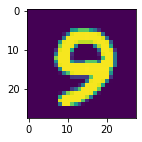

rotation degree 0.0 Mean of std of each class : 0.0569 Predict : 9 Softmax : 0.84
Finished angle:0.0.
rotation degree 40.0 Mean of std of each class : 0.0558 Predict : 9 Softmax : 0.84
Finished angle:40.0.
rotation degree 80.0 Mean of std of each class : 0.1056 Predict : 9 Softmax : 0.46
Finished angle:80.0.
rotation degree 120.0 Mean of std of each class : 0.0893 Predict : 8 Softmax : 0.48
Finished angle:120.0.
rotation degree 160.0 Mean of std of each class : 0.0667 Predict : 5 Softmax : 0.66
Finished angle:160.0.
rotation degree 200.0 Mean of std of each class : 0.0390 Predict : 6 Softmax : 0.90
Finished angle:200.0.
rotation degree 240.0 Mean of std of each class : 0.0802 Predict : 6 Softmax : 0.65
Finished angle:240.0.
rotation degree 280.0 Mean of std of each class : 0.1024 Predict : 0 Softmax : 0.56
Finished angle:280.0.
rotation degree 320.0 Mean of std of each class : 0.0865 Predict : 2 Softmax : 0.56
Finished angle:320.0.
rotation degree 360.0 Mean of std of each class : 0.05

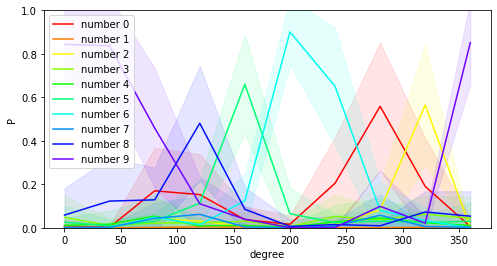

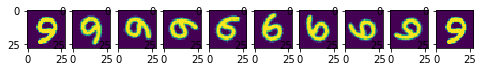

In [42]:
test_uncertainty_rotation_Eoutput(T=500,num=9)

In [14]:
torch.save(model.state_dict(), "./model_mcdropout_4couches_class.pt")